# Amazon Food Reviews - [Decision Trees]

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

## Excerpt 
1. Applied Decision Trees on Different Featurization of Data viz. BOW(uni-gram,bi-gram), tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec <br>
2. Used both Grid Search with random 30 points for getting the best max_depth <br>
3. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix using seaborne<br>
4. Plotted feature importance recieved from the decision tree classifier<br>

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)


### Objective:- Review Polarity
Given a review, determine the review is positive or negative

#### Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

### Loading the data

In [6]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews limit 1000
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,0,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,b'dont know cactus tequila uniqu combin ingred...
1,232,253,B0002567IW,A1SSKFPX72MSMR,"Janna M. Sicard ""missjanna""",0,0,1,1344556800,Sad outcome,"Five minutes in, one tentacle was bitten off, ...",b'five minut one tentacl bitten ball insid cra...
2,171,188,B00029XIZI,A2S72TUJDQUBMH,Nadia,0,0,0,1236124800,Miracle,My Scotties were full of hot spots and when I ...,b'scotti full hot spot use within week hot spo...
3,932,1011,B0002MKFEM,A3QLX72AO0DD5Z,Carlito Picache,1,2,0,1226361600,Way too salty,I tried this and I found it too salty.<br />Pl...,b'tri found salti plus ate fish sauc fish real...
4,893,969,B0002XIB2Y,A3NV17B17PFB7G,Susan,3,3,0,1228176000,WONDERFUL gravy!,"This gravy mix is excellent ... except, don't ...",b'gravi mix excel except dont use water call u...


In [7]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,998.000000,998.000000,998.000000,998.000000,998.000000,9.980000e+02
mean,500.041082,542.221443,1.229459,1.668337,0.157315,1.289901e+09
std,288.715825,311.736605,2.687027,3.178605,0.364280,4.954508e+07
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.107821e+09
25%,250.250000,272.500000,0.000000,0.000000,0.000000,1.257898e+09
50%,500.500000,544.500000,0.000000,1.000000,0.000000,1.303344e+09
75%,749.750000,810.750000,1.000000,2.000000,0.000000,1.330711e+09
max,999.000000,1082.000000,43.000000,47.000000,1.000000,1.351210e+09


In [8]:
df.shape
df['Score'].size

998

## For EDA and Text Preprecessing Refer other ipynb notebook<b>

In [44]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df["Score"]

0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
      ..
968    1
969    1
970    1
971    1
972    1
973    1
974    1
975    1
976    1
977    1
978    1
979    1
980    1
981    1
982    1
983    1
984    1
985    1
986    1
987    1
988    1
989    1
990    1
991    1
992    1
993    1
994    1
995    1
996    1
997    1
Name: Score, dtype: int64

In [45]:
#Taking Sample Data
n_samples = 900
df_sample = df.sample(n_samples)

###Sorting as we want according to time series
df_sample.sort_values('Time',inplace=True) 
df_sample.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
33,973,1054,B000CQG862,A3HXPEOW4KN19,Dawn Marakby,2,2,1,1158278400,Best Tea EVER!!,"I ordered the White Christmas, Christmas Eve, ...",b'order white christma christma eve christma m...
532,32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,1,1163376000,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,b'mccann instant oatmeal great must oatmeal sc...
31,975,1056,B000CQG862,AGV2SUHV9P47T,M. Power,0,0,1,1163376000,Makes everything better,Christmas Eve tea (which does not actually con...,b'christma eve tea actual contain tea christma...
539,33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,1,1166313600,Good Instant,This is a good instant oatmeal from the best o...,b'good instant oatmeal best oatmeal brand use ...
368,296,325,B000JEHAHS,A2CU16YU1KEOUY,"Hurricane Ridge ""Chris""",5,19,1,1168300800,Never Arrived,So we cancelled the order. It was cancelled w...,b'cancel order cancel without problem posit note'
369,295,322,B000JEHAHS,AJ7Q49CTJ1BOC,24fan,4,4,1,1168473600,Great gag gift,Put this in my husbands stocking for Christmas...,b'put husband stock christma hit'
356,315,347,B000HKYP9A,AEIAXBIMAO9T0,"Heidi ""Hydez54""",0,0,1,1168473600,Love the Fresh Food Feeder!!,This product is amazing. I know a few people w...,b'product amaz know peopl littl one use love s...
358,311,340,B000HKYP9A,A2CHZ5Q2EF3IR3,Mommy with an Opinion,2,2,1,1168905600,"Love, Love, Love These!",Bought a set of two when my son was about 6 mo...,b'bought set two son month start take whenev w...
77,897,973,B000F0G75W,A3QOSBTILZ84HY,"Junie ""finaj""",0,0,1,1173312000,Eco sugar,Its great to be able to get sugar this way.Its...,b'great abl get sugar way good eat go use suga...
237,463,501,B000G6RYNE,A2LGWBIT9WCTVA,D. Gesswein,0,0,1,1173312000,Excellent chip!,I bought these for the office and no one can p...,b'bought offic one put order today week didnt ...


In [46]:
#Saving 50k samples in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_dt")

In [47]:
#Opening from samples from file
df_sample = openfromfile("sample_dt")

In [49]:
df_sample['CleanedText'].values

array([b'order white christma christma eve christma morn blend last year holiday fell love christma eve smoothest bunch wonder flavor use ice tea year round honest say never got tea much tri stash tea sent licoric lemon flavor father call ask gotten neighbor want get wife tri addict visit stashtea websit lot tea relat bit baubl make perfect hostess gift holiday along plate cooki',
       b'mccann instant oatmeal great must oatmeal scrape togeth two three minut prepar escap fact howev even best instant oatmeal nowher near good even store brand oatmeal requir stovetop prepar still mccann good get instant oatmeal even better organ brand tri varieti mccann varieti pack tast good prepar microwav ad boil water conveni extrem time issu mccann use actual cane sugar instead high fructos corn syrup help decid buy product real sugar tast better harm stuff one thing like though mccann use thicken oat plus water plus heat make creami tasti oatmeal without need guar gum conveni product mayb guar gum

# Decision Trees Model  using Different Featurization in NLP

![alt text](https://image.slidesharecdn.com/decision-tree-final-170421102129/95/decision-tree-algorithm-analysis-machine-learning-algorithm-data-science-training-edureka-12-638.jpg?cb=1492771312)

Here I have use GINI Impurity for building decision trees

![img](https://chrisalbon.com/images/machine_learning_flashcards/Gini_Index_print.png)

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)
y_train

Train Data Size:  (630, 3188)
Test Data Size:  (270, 3188)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [53]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(60, 3188) (57, 3188)
(117, 3188) (57, 3188)
(174, 3188) (57, 3188)
(231, 3188) (57, 3188)
(288, 3188) (57, 3188)
(345, 3188) (57, 3188)
(402, 3188) (57, 3188)
(459, 3188) (57, 3188)
(516, 3188) (57, 3188)
(573, 3188) (57, 3188)


![i](https://i.stack.imgur.com/fXZ6k.png)

### Finding the best 'max_depth' using Forward Chaining Cross Validation or Time Series CV 

In [23]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"gsv.uni")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.48 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'max_depth': 11}
Best Accuracy: 100.00%


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished


In [37]:
# Run this program on your local python 
# interpreter, provided you have installed 
# the required libraries. 

# Importing the required packages 
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix 
#from sklearn.cross_validation import train_test_split 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
#from sklearn import cross_validation

# Function importing Dataset 
def importdata(): 
	balance_data = pd.read_csv( 
'https://archive.ics.uci.edu/ml/machine-learning-'+
'databases/balance-scale/balance-scale.data', 
	sep= ',', header = None) 
	
	# Printing the dataswet shape 
	print ("Dataset Lenght: ", len(balance_data)) 
	print ("Dataset Shape: ", balance_data.shape) 
	
	# Printing the dataset obseravtions 
	print ("Dataset: ",balance_data.head()) 
	return balance_data 

# Function to split the dataset 
def splitdataset(balance_data): 

	# Seperating the target variable 
	X = balance_data.values[:, 1:5] 
	Y = balance_data.values[:, 0] 

	# Spliting the dataset into train and test 
	X_train, X_test, y_train, y_test = train_test_split( 
	X, Y, test_size = 0.3, random_state = 100) 
	
	return X, Y, X_train, X_test, y_train, y_test 
	
# Function to perform training with giniIndex. 
def train_using_gini(X_train, X_test, y_train): 

	# Creating the classifier object 
	clf_gini = DecisionTreeClassifier(criterion = "gini", 
			random_state = 100,max_depth=11, min_samples_leaf=5) 

	# Performing training 
	clf_gini.fit(X_train, y_train) 
	return clf_gini 
	
# Function to perform training with entropy. 
def tarin_using_entropy(X_train, X_test, y_train): 

	# Decision tree with entropy 
	clf_entropy = DecisionTreeClassifier( 
			criterion = "entropy", random_state = 100, 
			max_depth = 11, min_samples_leaf = 5) 

	# Performing training 
	clf_entropy.fit(X_train, y_train) 
	return clf_entropy 


# Function to make predictions 
def prediction(X_test, clf_object): 

	# Predicton on test with giniIndex 
	y_pred = clf_object.predict(X_test) 
	print("Predicted values:") 
	print(y_pred) 
	return y_pred 
	
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
	
	print("Confusion Matrix: ", 
		confusion_matrix(y_test, y_pred)) 
	
	print ("Accuracy : ", 
	accuracy_score(y_test,y_pred)*100) 
	
	print("Report : ", 
	classification_report(y_test, y_pred)) 

# Driver code 
def main(): 
	
	# Building Phase 
	#data = importdata() 
	#X, Y, X_train, X_test, y_train, y_test = splitdataset(data) 
	clf_gini = train_using_gini(X_train, X_test, y_train) 
	clf_entropy = tarin_using_entropy(X_train, X_test, y_train) 
	
	# Operational Phase 
	print("Results Using Gini Index:") 
	
	# Prediction using gini 
	y_pred_gini = prediction(X_test, clf_gini) 
	cal_accuracy(y_test, y_pred_gini) 
	
	print("Results Using Entropy:") 
	# Prediction using entropy 
	y_pred_entropy = prediction(X_test, clf_entropy) 
	cal_accuracy(y_test, y_pred_entropy) 
	
	
# Calling main function 
if __name__=="__main__": 
	main() 

Results Using Gini Index:
Predicted values:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Confusion Matrix:  [[150]]
Accuracy :  100.0
Report :                precision    recall  f1-score   support

           1       1.00      1.00      1.00       150

   micro avg       1.00      1.00      1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Results Using Entropy:
Predicted values:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

<b>Note: Not ideal to run Decision Trees on data with such huge features as it will take very long hours to train hence taking only 300 as max depth<b>

In [34]:
gsv = openfromfile("gsv.uni")
x=[]
y=[]
for a in gsv.cv_results_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(-10,300)
plt.ylim(0.2,0.5)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

TypeError: 'GridSearchCV' object is not iterable

In [25]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=291)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 100.000%
Precision on test set: 1.000
Recall on test set: 1.000
F1-Score on test set: 1.000
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



ValueError: Shape of passed values is (1, 1), indices imply (2, 2)

![alt](https://chrisalbon.com/images/machine_learning_flashcards/Feature_Importance_print.png)

### Top 25 most important features

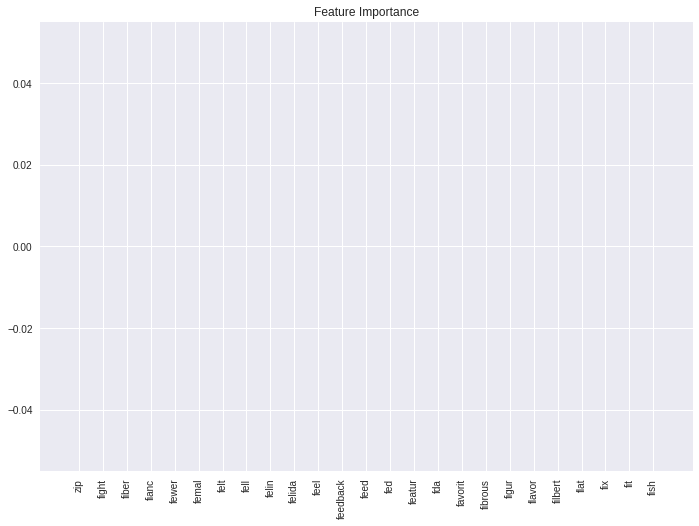

In [26]:
# Calculate feature importances from decision trees
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = uni_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

### bi-gram

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (350, 12704)
Test Data Size:  (150, 12704)


In [29]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'max_depth': 7}
Best Accuracy: 100.00%


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.0s finished


<b>Note: Not ideal to run Decision Trees on data with such huge features as it will take very long hours to train hence taking only 300 as max depth<b>

In [31]:
from sklearn.model_selection import GridSearchCV
gsv = openfromfile("gsv_bi")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.35,0.5)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [32]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=73)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 100.000%
Precision on test set: 1.000
Recall on test set: 1.000
F1-Score on test set: 1.000
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



ValueError: Shape of passed values is (1, 1), indices imply (2, 2)

### Top 25 most important features

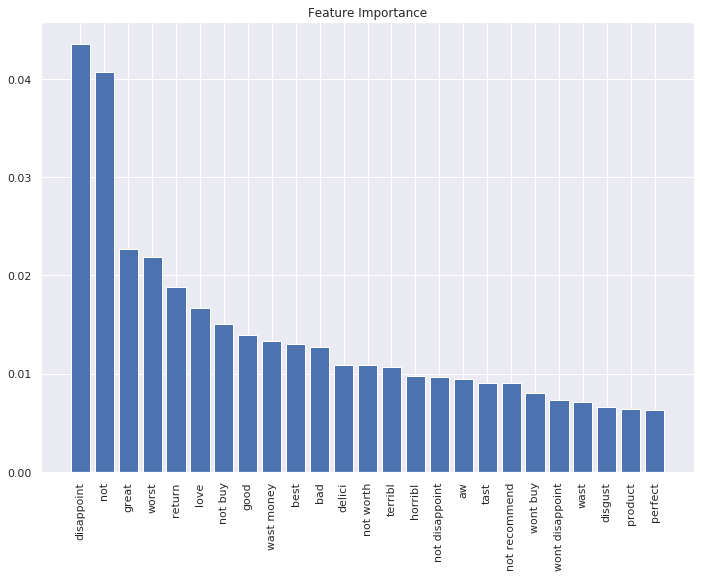

In [19]:
# Calculate feature importances from decision trees
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = bi_gram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

# tf-idf


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [20]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000, 637926)
Test Data Size:  (15000, 637926)
CPU times: user 7.73 s, sys: 36 ms, total: 7.76 s
Wall time: 7.77 s


In [28]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"Decision Trees/gsv_tfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 207.1min finished


Best HyperParameter:  {'max_depth': 231}
Best Accuracy: 46.51%


<b>Note: Not ideal to run Decision Trees on data with such huge features as it will take very long hours to train hence taking only 300 as max depth<b>

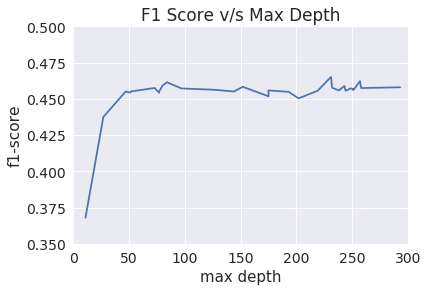

In [58]:
gsv = openfromfile("Decision Trees/gsv_tfidf")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.35,0.5)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy on test set: 84.427%
Precision on test set: 0.545
Recall on test set: 0.515
F1-Score on test set: 0.530
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



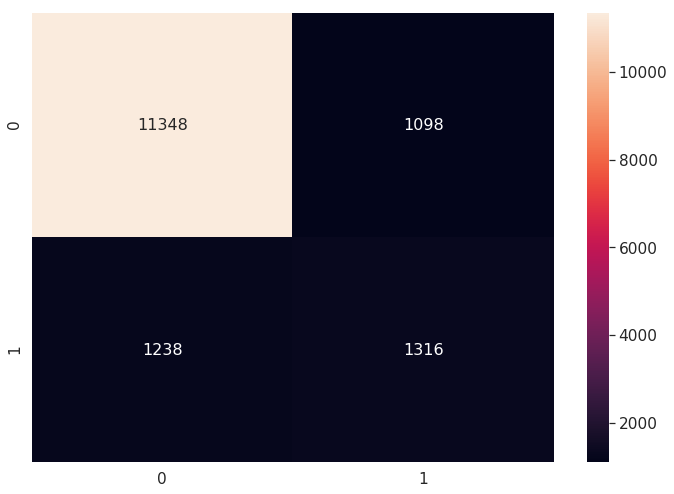

In [21]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=231)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Top 25 most important features

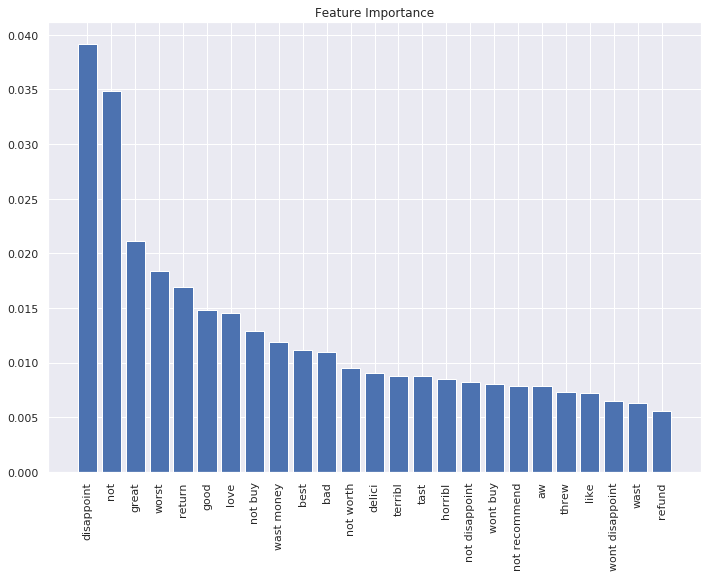

In [22]:
# Calculate feature importances from decision trees
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = tfidf.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [6]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [7]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

3000000

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [66]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in df_sample['CleanedText_NoStem']:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

CPU times: user 24.1 s, sys: 56 ms, total: 24.2 s
Wall time: 24.2 s


In [67]:
np.isnan(avg_vec_google).any()

False

In [68]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = df_sample['Score'][mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(50000, 300)
(50000,)


In [69]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new.values,test_size=0.3,shuffle=False)

In [13]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"Decision Trees/gsv_aw2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 93.9min finished


Best HyperParameter:  {'max_depth': 20}
Best Accuracy: 31.83%


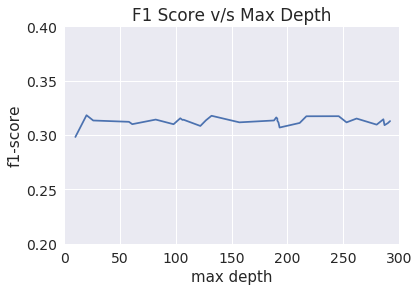

In [65]:
gsv = openfromfile("Decision Trees/gsv_aw2v")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.2,0.4)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy on test set: 79.380%
Precision on test set: 0.380
Recall on test set: 0.333
F1-Score on test set: 0.355
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



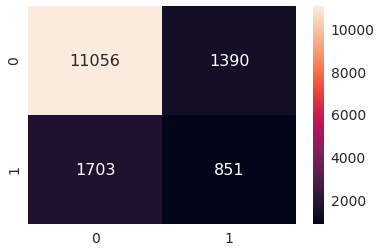

In [71]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [15]:
importances = clf.feature_importances_
print(importances)

[ 0.00175945  0.00349239  0.01029238  0.00340061  0.0131046   0.00225063
  0.00292788  0.00128508  0.00468368  0.00255785  0.00348384  0.00467724
  0.00243404  0.00283186  0.00357978  0.00191578  0.00231668  0.00237386
  0.00143282  0.00589543  0.00219676  0.00083783  0.00210978  0.0021752
  0.00601339  0.00354034  0.01229339  0.00165709  0.00331596  0.00707421
  0.00249374  0.0007818   0.00481606  0.00156479  0.00227053  0.00379202
  0.0062249   0.0032119   0.00117164  0.0009885   0.0010391   0.00333548
  0.00292439  0.00337951  0.00043645  0.00096249  0.00078105  0.00324372
  0.00570326  0.00180966  0.00076963  0.00335505  0.00047165  0.00237379
  0.00217202  0.00327203  0.00207924  0.00312069  0.00238702  0.00067064
  0.00195518  0.00306831  0.00040049  0.00112416  0.03474253  0.00416799
  0.00461279  0.00421409  0.00197815  0.00273081  0.00317363  0.00448606
  0.0019258   0.00417622  0.00391924  0.00376488  0.00197057  0.0012056
  0.00359533  0.00099015  0.00400184  0.00546367  0.0

But since the features in Word2Vec aren't interpretable its needless to get the feature importance

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [11]:
%%time
#Taking Sample Data as it was taking more that 10 hours to computer this block
n_samples = 25000
df_sample_new = df_sample.sample(n_samples)

###Sorting as we want according to time series
df_sample_new.sort_values('Time',inplace=True) 

###tf-idf with No Stemming
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams

tfidf_vec_new = tfidf.fit_transform(df_sample_new['CleanedText_NoStem'].values)

print(tfidf_vec_new.shape)

# tf-idf came up with 2.9 million features for the data corpus
# from sklearn.decomposition import TruncatedSVD

# tsvd_tfidf_ns = TruncatedSVD(n_components=300)#No of components as total dimensions
# tsvd_tfidf_vec_ns = tsvd_tfidf_ns.fit_transform(tfidf_vec_ns)
# print(tsvd_tfidf_ns.explained_variance_ratio_[:].sum())
features = tfidf.get_feature_names()

(25000, 589499)
CPU times: user 6.15 s, sys: 16 ms, total: 6.16 s
Wall time: 6.16 s


In [52]:
df_sample_new

NameError: name 'df_sample_new' is not defined

In [ ]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in df_sample_new['CleanedText_NoStem'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_ns[review,features.index(word)])
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
#             print(review)
            pass
    sent_vec /= weighted_sum
#     print(sent_vec)
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

In [72]:
#Precomputed File
tfidf_w2v_vec_google = openfromfile("tfidf_w2v_vec_google")
#Loading the same samples as using precomuted file
df_sample_new = openfromfile("df_sample_new_tfidfw2vec")

In [73]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

In [76]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
savetofile(gsv,"Decision Trees/gsv_tfidfaw2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 44.0min finished


Best HyperParameter:  {'max_depth': 57}
Best Accuracy: 29.07%


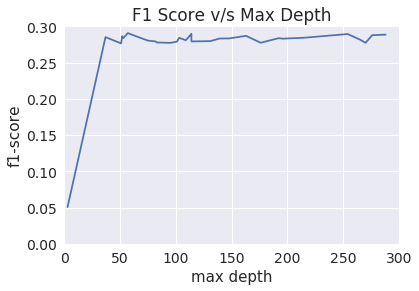

In [79]:
gsv = openfromfile("Decision Trees/gsv_tfidfaw2v")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,300)
plt.ylim(0.0,0.3)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

Accuracy on test set: 77.093%
Precision on test set: 0.298
Recall on test set: 0.310
F1-Score on test set: 0.304
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



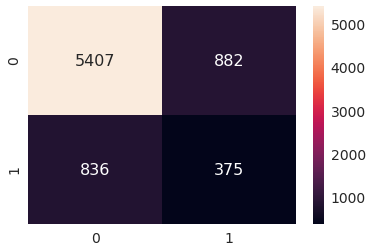

In [80]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=57)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Performance Table

![image](https://image.ibb.co/kokTjJ/6_Decision_Trees.png)

## Conclusions
1. Decision Trees on Uni-gram, bi-gram and tfidf would have taken forever if had taken all the dimensions as it had huge dimension and hence tried with max 300 as max_depth
2. Bi-gram Featurization(max_depth=73) gave the best results with accuracy of 85.11% and F1-score of 0.513
3. Plotted feature importance for Uni-gram, bi-gram and tfidf but not for Avg Word2Vec and Tfidf Avg Word2Vec as Word2Vec featurizations are highly co-related hence can't directly get the feature importance